In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import glob
import seaborn as sns
import random

from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_error, r2_score
from sklearn.linear_model import LinearRegression, ElasticNet
from lightgbm import LGBMRegressor
from sklearn.tree import DecisionTreeRegressor

import tensorflow as tf
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import LSTM, Dropout, Bidirectional, Dense


In [ ]:
path = "/content/faststore/"
all_files = glob.glob(path + "/*.csv")

li = []

for filename in all_files:
    df = pd.read_csv(filename, index_col=None, header=0, delimiter=";")
    li.append(df)

new_df = pd.concat(li, axis=0, ignore_index=True)

In [ ]:
new_df.columns = new_df.columns.str.replace("\t", "")

In [ ]:
col = ["Timestamp [ms]", 'CPU cores', 'CPU capacity provisioned [MHZ]', 'CPU usage [MHZ]', 'Memory usage [KB]']

In [ ]:
df = new_df[col]

In [ ]:
df = df.sort_values("Timestamp [ms]")
df = df.groupby("Timestamp [ms]").mean()

In [ ]:
y = df['CPU usage [MHZ]']

In [ ]:
scaler = MinMaxScaler()
df_scaled = pd.DataFrame(scaler.fit_transform(df), columns=df.columns)

In [ ]:
df_scaled = df_scaled.set_index(df.index)

In [ ]:
for col in df_scaled.columns:
    for i in range(1,1001):
        df_scaled[col + f" {i}shifted"] = df_scaled[col].shift(i)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  This is separate from the ipykernel package so we can avoid doing imports until


In [ ]:
df_scaled = df_scaled.dropna()

In [ ]:
x = df_scaled.drop(['CPU capacity provisioned [MHZ]', "CPU cores", "Memory usage [KB]", "CPU usage [MHZ]"], axis=1)

In [ ]:
train = x.head(int(df_scaled.shape[0] * 0.9))
test = x.tail(int(df_scaled.shape[0] * 0.1))

y_train = y.head(int(df_scaled.shape[0] * 0.9))
y_test = y.tail(int(df_scaled.shape[0] * 0.1))

In [ ]:
train.shape, test.shape, y_train.shape, y_test.shape

((55917, 4000), (6213, 4000), (55917,), (6213,))

In [ ]:
def get_model_score(pipeline, X_train, X_test, y_train, y_test):

    pipeline.fit(X_train, y_train)

    r2_score_train = r2_score(y_train, pipeline.predict(X_train))
    r2_score_test = r2_score(y_test, pipeline.predict(X_test))

    mae_train = mean_absolute_error(y_train, pipeline.predict(X_train))
    mae_test = mean_absolute_error(y_test, pipeline.predict(X_test))

    mse_train = mean_squared_error(y_train, pipeline.predict(X_train))
    mse_test = mean_squared_error(y_test, pipeline.predict(X_test))

    print("R2 score_train: ", r2_score_train)
    print("R2 score_test: ", r2_score_test)
    print("Train Mean Squeare Error: ", mse_train)
    print("Test Mean Squeare Error: ", mse_test)
    print("Train Mean Abosulte Error: ", mae_train)
    print("Test Mean Abosulte Error: ", mae_test)

In [ ]:
def get_scores(pipeline, X_train, X_test, y_train, y_test):

    r2_score_train = r2_score(y_train, pipeline.predict(X_train))
    r2_score_test = r2_score(y_test, pipeline.predict(X_test))

    mae_train = mean_absolute_error(y_train, pipeline.predict(X_train))
    mae_test = mean_absolute_error(y_test, pipeline.predict(X_test))

    mse_train = mean_squared_error(y_train, pipeline.predict(X_train))
    mse_test = mean_squared_error(y_test, pipeline.predict(X_test))

    rmse_train = mean_squared_error(y_train, pipeline.predict(X_train), squared=False)
    rmse_test = mean_squared_error(y_test, pipeline.predict(X_test), squared=False)

    print("R2 score_train: ", r2_score_train)
    print("R2 score_test: ", r2_score_test)
    print("Train Mean Squeare Error: ", mse_train)
    print("Test Mean Squeare Error: ", mse_test)
    print("Train Root Mean Squeare Error: ", rmse_train)
    print("Test Root Mean Squeare Error: ", rmse_test)
    print("Train Mean Abosulte Error: ", mae_train)
    print("Test Mean Abosulte Error: ", mae_test)

In [ ]:
get_model_score(LinearRegression(), train, test, y_train, y_test)

R2 score_train:  1.0
R2 score_test:  -0.6978824853560635
Train Mean Squeare Error:  3.656847832885403e-24
Test Mean Squeare Error:  59335.8733964335
Train Mean Abosulte Error:  1.3840589471107848e-12
Test Mean Abosulte Error:  74.30168789498752


In [ ]:
get_model_score(ElasticNet(), train, test, y_train, y_test)

R2 score_train:  0.6847637727914717
R2 score_test:  -0.30949966438457355
Train Mean Squeare Error:  86588.72436762051
Test Mean Squeare Error:  45763.06485799025
Train Mean Abosulte Error:  151.2112199470243
Test Mean Abosulte Error:  111.86898368237621


In [ ]:
get_model_score(LGBMRegressor(), train, test, y_train, y_test)

R2 score_train:  0.9999672932402698
R2 score_test:  -0.6980652743533362
Train Mean Squeare Error:  8.983855149874529
Test Mean Squeare Error:  59342.261320741556
Train Mean Abosulte Error:  0.3878329739418105
Test Mean Abosulte Error:  74.30135437871986


In [ ]:
get_model_score(DecisionTreeRegressor(), train, test, y_train, y_test)

R2 score_train:  1.0
R2 score_test:  -0.6979861391250832
Train Mean Squeare Error:  2.62316080480119e-13
Test Mean Squeare Error:  59339.49578312319
Train Mean Abosulte Error:  7.04116960114605e-08
Test Mean Abosulte Error:  74.3053381878517


In [ ]:
lgbm = LGBMRegressor(min_data_in_leaf=70, max_depth=i)
lgbm.fit(train, y_train)
get_scores(lgbm, train, test, y_train, y_test)

R2 score_train:  0.9999096118110006
R2 score_test:  -0.698021668866281
Train Mean Squeare Error:  24.827723807850493
Test Mean Squeare Error:  59340.73744044854
Train Root Mean Squeare Error:  4.982742598996109
Test Root Mean Squeare Error:  243.5995431860424
Train Mean Abosulte Error:  0.4561812764881908
Test Mean Abosulte Error:  74.30464763914732


In [ ]:
lgbm_preds = lgbm.predict(test)

In [ ]:
lgbm_preds

array([1.01375436e-02, 7.30521955e+00, 1.01375436e-02, ...,
       1.01375436e-02, 1.01375436e-02, 2.59622986e+01])

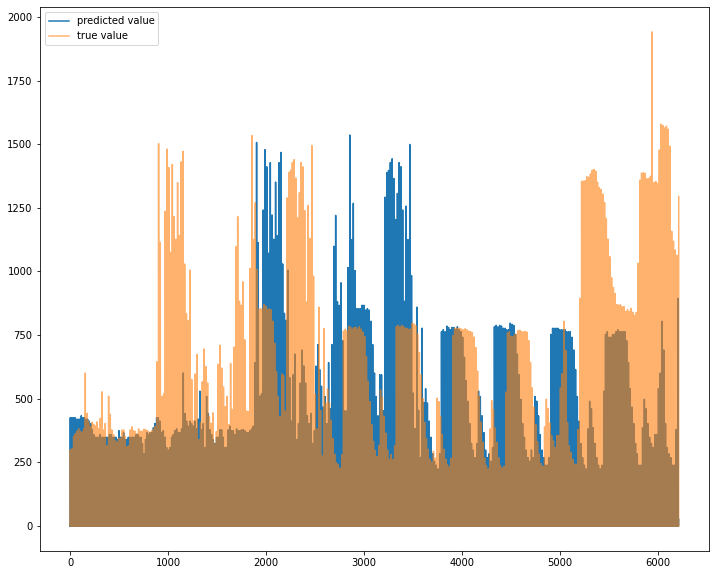

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(lgbm_preds)
plt.plot(y_test.to_numpy(), alpha=0.6)
plt.legend(["predicted value", "true value"])

In [ ]:
y_test.to_numpy()

array([   7.40605956,    0.        ,    0.        , ...,    0.        ,
          0.        , 1294.61770404])

In [ ]:
model = Sequential([
                    Dense(20, activation='relu'),
                    Dropout(0.1),
                    Dense(40, activation='relu'),
                    Dropout(0.1),
                    Dense(80, activation='relu'),
                    Dropout(0.1),
                    Dense(120, activation='relu'),
                    Dropout(0.1),
                    Dense(120, activation='relu'),
                    Dropout(0.1),
                    Dense(80, activation='relu'),
                    Dropout(0.1),
                    Dense(40, activation='relu'),
                    Dropout(0.1),
                    Dense(20, activation='relu'),
                    Dropout(0.1),
                    Dense(1)
])
model.compile(loss='mean_squared_error', optimizer='adam')

In [ ]:
model.summary()

Model: "sequential_7"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_26 (Dense)            (None, 20)                80020     
                                                                 
 dropout_23 (Dropout)        (None, 20)                0         
                                                                 
 dense_27 (Dense)            (None, 40)                840       
                                                                 
 dropout_24 (Dropout)        (None, 40)                0         
                                                                 
 dense_28 (Dense)            (None, 80)                3280      
                                                                 
 dropout_25 (Dropout)        (None, 80)                0         
                                                                 
 dense_29 (Dense)            (None, 120)              

In [ ]:
history = model.fit(
    train.to_numpy(), y_train,
    epochs=200,
    batch_size=32,
    validation_split=0.2,
    shuffle=False
)

Epoch 1/200
1398/1398 [==============================] - 9s 6ms/step - loss: 184558.2344 - val_loss: 8110.3477
Epoch 2/200
1398/1398 [==============================] - 8s 6ms/step - loss: 124197.0781 - val_loss: 5608.4565
Epoch 3/200
1398/1398 [==============================] - 7s 5ms/step - loss: 112029.4219 - val_loss: 5227.7983
Epoch 4/200
1398/1398 [==============================] - 7s 5ms/step - loss: 102018.1797 - val_loss: 5450.1953
Epoch 5/200
1398/1398 [==============================] - 7s 5ms/step - loss: 75857.9375 - val_loss: 5894.8882
Epoch 6/200
1398/1398 [==============================] - 7s 5ms/step - loss: 71492.3125 - val_loss: 7278.1572
Epoch 7/200
1398/1398 [==============================] - 7s 5ms/step - loss: 67311.0859 - val_loss: 6743.5308
Epoch 8/200
1398/1398 [==============================] - 7s 5ms/step - loss: 68694.1094 - val_loss: 9189.6191
Epoch 9/200
1398/1398 [==============================] - 8s 6ms/step - loss: 67259.5938 - val_loss: 9671.0391
Epoch 

In [ ]:
model.save("/content/my_mode")

INFO:tensorflow:Assets written to: /content/my_mode/assets


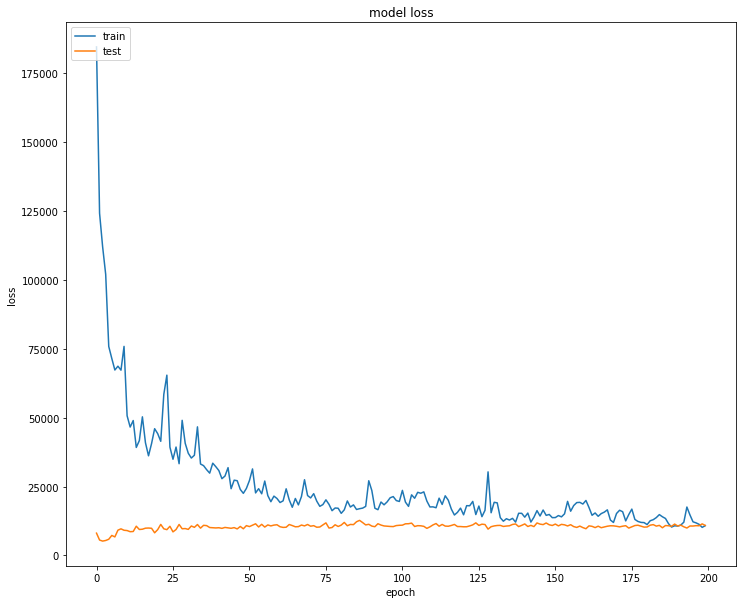

In [ ]:
plt.figure(figsize =  (12,10))
# summarize history for accuracy
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.ylabel('loss')
plt.xlabel('epoch')
plt.title('model loss')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

In [ ]:
mean_absolute_error(y_test, model.predict(test.to_numpy()))

64.77895036488002

In [ ]:
mean_absolute_error(y_train, model.predict(train.to_numpy()))

97.36432047291753

In [ ]:
mean_squared_error(y_train, model.predict(train.to_numpy()), squared=False)

276.9230536433658

In [ ]:
mean_squared_error(y_test, model.predict(test.to_numpy()), squared=False)

213.73785377434317

In [ ]:
!zip -r /content/my_mode.zip /content/my_mode

  adding: content/my_mode/ (stored 0%)
  adding: content/my_mode/keras_metadata.pb (deflated 93%)
  adding: content/my_mode/variables/ (stored 0%)
  adding: content/my_mode/variables/variables.data-00000-of-00001 (deflated 30%)
  adding: content/my_mode/variables/variables.index (deflated 70%)
  adding: content/my_mode/saved_model.pb (deflated 91%)
  adding: content/my_mode/assets/ (stored 0%)


In [ ]:
from google.colab import files
files.download("/content/my_mode.zip")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
new_tf_model = load_model("/content/my_mode")

In [ ]:
tf_predict = new_tf_model.predict(test.to_numpy())

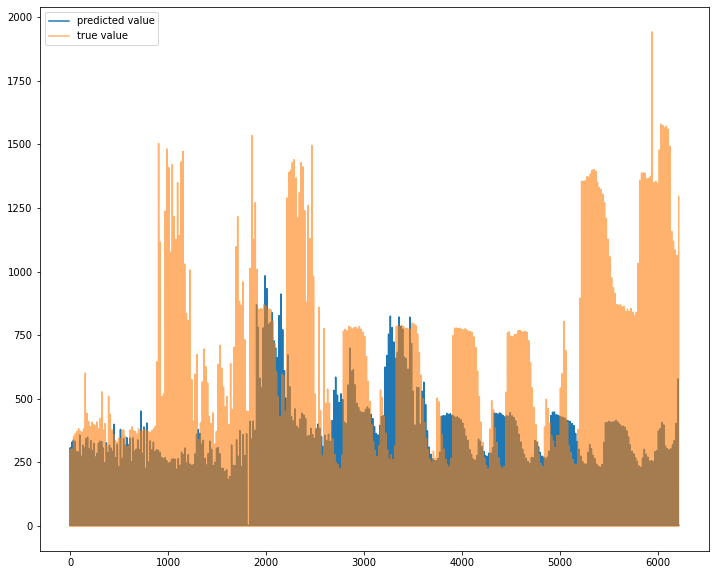

In [ ]:
plt.figure(figsize=(12,10))
plt.plot(tf_predict)
plt.plot(y_test.to_numpy(), alpha=0.6)
plt.legend(["predicted value", "true value"])

In [ ]:
len(tf_predict)

55917

In [ ]:
len(y_test.to_numpy())

6213

In [ ]:
tf_predict

array([[417.77042  ],
       [412.73407  ],
       [404.1756   ],
       ...,
       [  3.0936184],
       [  3.0936184],
       [  3.0936193]], dtype=float32)